# Building your Convolutional Neural Network: Step by Step

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [2]:
train_dataset = h5py.File('train_signs.h5', "r")
x_train = np.array(train_dataset["train_set_x"][:]) 
y_train = np.array(train_dataset["train_set_y"][:])

test_dataset = h5py.File('test_signs.h5', "r")
x_test = np.array(test_dataset["test_set_x"][:]) 
y_test = np.array(test_dataset["test_set_y"][:])

In [3]:
X_train = x_train
Y_train = np.reshape(np.eye(6)[y_train],(-1,6))

X_test = x_test
Y_test = np.reshape(np.eye(6)[y_test],(-1,6))

It's a 2


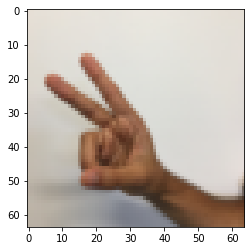

In [4]:
index = 6
plt.imshow(X_train[index,:,:,:])
print("It's a {}".format(y_train[index]))

In [5]:
class Lambda():
    
    def __init__(self):
        self.weights = []

    def __call__(self, inputs):
        return inputs/255.
    
class Conv2D():
    
    def __init__(self, filters, kernel_size, strides, padding):
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.weights = []
        self.built = False
        
    def add_weight(self, shape):
        var_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=var_init, trainable=True)
            
    def build(self, input_dims):
        self.h = input_dims[0]
        self.w = input_dims[1]
        self.c = input_dims[2]
        self.f_h = self.kernel_size[0]
        self.f_w = self.kernel_size[1]
        self.s_h = self.strides[0]
        self.s_w = self.strides[1]
        if self.padding=='valid':
            p_h_1 = 0
            p_h_2 = 0
            p_w_1 = 0
            p_w_2 = 0
        else:
            if self.padding=='same':
                p_h_1 = ((self.h-1)*self.s_h-self.h+self.f_h)//2
                p_h_2 = ((self.h-1)*self.s_h-self.h+self.f_h)//2+((self.h-1)*self.s_h-self.h+self.f_h)%2
                p_w_1 = ((self.w-1)*self.s_w-self.w+self.f_w)//2
                p_w_2 = ((self.w-1)*self.s_w-self.w+self.f_w)//2+((self.w-1)*self.s_w-self.w+self.f_w)%2
            else:
                p_h_1 = self.padding[0]
                p_h_2 = self.padding[1]
                p_w_1 = self.padding[2]
                p_w_2 = self.padding[3] 
        self.paddings = [[0,0],[p_h_1,p_h_2],[p_w_1,p_w_2],[0,0]]
        self.q_w = (self.w+p_w_1+p_w_2-self.f_w)//self.s_w
        self.q_h = (self.h+p_h_1+p_h_2-self.f_h)//self.s_h
        self.k = self.add_weight(shape=(self.f_h,self.f_w,self.c,self.filters))
        self.weights.append(self.k)
        self.b = self.add_weight(shape=(1,self.filters))
        self.weights.append(self.b)
        self.built = True

    def __call__(self, inputs):
        if not self.built:
            self.build(input_dims=inputs.shape[1:])
        v = tf.pad(inputs, paddings=self.paddings)
        outputs = []
        for a in range(self.q_h+1):
            outputs_ = []
            for b in range(self.q_w+1):               
                z = tf.einsum('ijkc, dijk ->dc', self.k, v[:,self.s_h*a:self.s_h*a+self.f_h,self.s_w*b:self.s_w*b+self.f_w,:]) + self.b    
                outputs_.append(tf.math.maximum(0., z))
            outputs.append(outputs_)
        return tf.transpose(tf.convert_to_tensor(outputs), perm=[2,0,1,3])
        
class MaxPool2D():
    
    def __init__(self, pool_size, strides, padding):
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        self.weights = []
        self.built = False
                    
    def build(self, input_dims):
        self.h = input_dims[0]
        self.w = input_dims[1]
        self.c = input_dims[2]
        self.f_h = self.pool_size[0]
        self.f_w = self.pool_size[1]
        self.s_h = self.strides[0]
        self.s_w = self.strides[1]
        if self.padding=='valid':
            p_h_1 = 0
            p_h_2 = 0
            p_w_1 = 0
            p_w_2 = 0
        else:
            if self.padding=='same':
                p_h_1 = ((self.h-1)*self.s_h-self.h+self.f_h)//2
                p_h_2 = ((self.h-1)*self.s_h-self.h+self.f_h)//2+((self.h-1)*self.s_h-self.h+self.f_h)%2
                p_w_1 = ((self.w-1)*self.s_w-self.w+self.f_w)//2
                p_w_2 = ((self.w-1)*self.s_w-self.w+self.f_w)//2+((self.w-1)*self.s_w-self.w+self.f_w)%2
            else:
                p_h_1 = self.padding[0]
                p_h_2 = self.padding[1]
                p_w_1 = self.padding[2]
                p_w_2 = self.padding[3] 
        self.paddings = [[0,0],[p_h_1,p_h_2],[p_w_1,p_w_2],[0,0]]
        self.q_w = (self.w+p_w_1+p_w_2-self.f_w)//self.s_w
        self.q_h = (self.h+p_h_1+p_h_2-self.f_h)//self.s_h
        self.built = True

    def __call__(self, inputs):
        if not self.built:
            self.build(input_dims=inputs.shape[1:])
        v = tf.pad(inputs, paddings=self.paddings)
        outputs = []
        for a in range(self.q_h+1):
            outputs_ = []
            for b in range(self.q_w+1):
                z = tf.math.reduce_max(v[:,self.s_h*a:self.s_h*a+self.f_h,self.s_w*b:self.s_w*b+self.f_w,:], axis=[1,2])
                outputs_.append(z)
            outputs.append(outputs_)
        return tf.transpose(tf.convert_to_tensor(outputs), perm=[2,0,1,3])
          
class Flatten():
    
    def __init__(self):
        self.weights = []
                
    def __call__(self, inputs):
        return tf.reshape(inputs, shape=(-1,inputs.shape[1]*inputs.shape[2]*inputs.shape[3]))
        
class Dense():
    
    def __init__(self, units):
        self.units = units
        self.weights = []
        self.built = False
        
    def add_weight(self, shape):
        var_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=var_init, trainable=True)
        
    def build(self, input_dims):
        self.w = self.add_weight(shape=(input_dims, self.units))
        self.weights.append(self.w)
        self.b = self.add_weight(shape=(1, self.units))
        self.weights.append(self.b)
        self.built = True

    def __call__(self, inputs):
        if not self.built:
            self.build(input_dims=inputs.shape[1])
        z = tf.matmul(inputs, self.w) + self.b
        u = tf.math.exp(z)
        return u/tf.math.reduce_sum(u, axis=1, keepdims=True)

In [6]:
class CategoricalCrossentropy():
            
    def __call__(self, y_true, y_pred):
        return -tf.math.reduce_mean(tf.math.reduce_sum(y_true*tf.math.log(y_pred), axis=1), axis=0)

In [7]:
class CategoricalAccuracy():
             
    def __call__(self, y_true, y_pred):
        y_pred_max = tf.cast(tf.math.argmax(y_pred, axis=1), dtype='float32')
        y_true_max = tf.cast(tf.math.argmax(y_true, axis=1), dtype='float32')
        return tf.math.reduce_mean(1-tf.square(tf.sign(y_true_max-y_pred_max)))

In [8]:
class Adam():

    def __init__(self, model, learning_rate, beta_1, beta_2, epsilon):
        self.model = model
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon= epsilon
        self.stop_training = False
        self.weights = []
        self.built = False
        
    def add_weight(self, shape):
        w_init = tf.zeros(shape=shape, dtype="float32")
        return  tf.Variable(initial_value=w_init, trainable=False)
    
    def build(self):
        for weight in self.model.weights:
            m = self.add_weight(shape=weight.shape)
            v = self.add_weight(shape=weight.shape)
            self.weights.append([m,v])
        self.built = True
            
    def apply_gradients(self, grads_and_vars):
        if not self.built:
            self.build()
        list_grads_and_vars = list(grads_and_vars)
        for i in range(len(list_grads_and_vars)):
            grad, var = list_grads_and_vars[i]
            m = self.weights[i][0]
            v = self.weights[i][1]
            self.weights[i][0].assign(self.beta_1*m + (1-self.beta_1)*grad)  
            self.weights[i][1].assign(self.beta_2*v + (1-self.beta_2)*grad*grad)
            m_ = (1/(1-self.beta_1))*self.weights[i][0]
            v_ = (1/(1-self.beta_2))*self.weights[i][1]
            var.assign(var - self.learning_rate*m_/(tf.math.sqrt(v_)+self.epsilon))

In [9]:
class ProgbarPrint():

    def __init__(self, model):
        self.model = model
    
    def on_epoch_begin(self, epoch):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs):
        now = tf.timestamp()
        time = now - self.start_time
        tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
        tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
        
class History():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class ReduceLROnPlateau():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class EarlyStopping():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [10]:
class Model():
    
    def __init__(self):
        self.h1 = Lambda()
        self.h2 = Conv2D(filters=8, 
                         kernel_size=(4,4), 
                         strides=(1,1), 
                         padding='same')
        self.h3 = MaxPool2D(pool_size=(8,8), 
                            strides=(8,8), 
                            padding='valid')
        self.h4 = Conv2D(filters=16, 
                         kernel_size=(2,2), 
                         strides=(1,1), 
                         padding='same')
        self.h5 = MaxPool2D(pool_size=(4,4), 
                            strides=(4,4), 
                            padding='valid')
        self.h6 = Flatten()
        self.h7 = Dense(units=Y_train.shape[1])
        self.layers = [self.h1, self.h2, self.h3, self.h4, self.h5, self.h6, self.h7]
        self.weights = []
        self.built = False
     
    def build(self):
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        self.built = True
        
    def __call__(self, inputs): 
        a1 = self.h1(inputs)
        a2 = self.h2(a1)
        a3 = self.h3(a2)
        a4 = self.h4(a3)
        a5 = self.h5(a4)
        a6 = self.h6(a5)
        y = self.h7(a6)
        if not self.built:
            self.build()
        return y 
                
    def train_step(self, X, Y):
        num_batches = X.shape[0]//self.batch_size
        for batch in range(num_batches+1):
            if batch<num_batches:
                X_batch = X[batch*self.batch_size:(batch+1)*self.batch_size]
                Y_batch = Y[batch*self.batch_size:(batch+1)*self.batch_size]
            else:
                X_batch = X[num_batches*self.batch_size:]
                Y_batch = Y[num_batches*self.batch_size:]
            with tf.GradientTape() as tape:
                H = self(X_batch)
                loss = self.loss(Y_batch, H)
            grads = tape.gradient(loss, self.weights)
            self.optimizer.apply_gradients(zip(grads, self.weights))
        H = self(X)
        loss = self.loss(Y, H)
        metric = self.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs
        
    def fit(self, X, Y, epochs=100, learning_rate=0.005, batch_size=64):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size 
        self.loss = CategoricalCrossentropy()
        self.metric = CategoricalAccuracy()
        self.optimizer = Adam(model=self, learning_rate=self.learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07) 
        self.callbacks = [ProgbarPrint(model=self),
                          History(model=self),
                          ReduceLROnPlateau(model=self, patience=20, error=0.0001, reduce_factor=0.1, min_learning_rate=0.001),
                          EarlyStopping(model=self, patience=50, error=0.0001)]
        tf.print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
        
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [11]:
model = Model()

model.fit(X_train, Y_train)

Train on 1080 samples
Epochs 1/100 - Loss: 1.791860580444336 - Metric: 0.1666666716337204
----- 71.651s -----
Epochs 2/100 - Loss: 1.791355013847351 - Metric: 0.20092593133449554
----- 75.179s -----
Epochs 3/100 - Loss: 1.7907549142837524 - Metric: 0.18425926566123962
----- 65.502s -----
Epochs 4/100 - Loss: 1.789555311203003 - Metric: 0.16851851344108582
----- 60.172s -----
Epochs 5/100 - Loss: 1.786730408668518 - Metric: 0.18981482088565826
----- 58.131s -----
Epochs 6/100 - Loss: 1.7810893058776855 - Metric: 0.21481481194496155
----- 58.183s -----
Epochs 7/100 - Loss: 1.7700203657150269 - Metric: 0.25833332538604736
----- 58.135s -----
Epochs 8/100 - Loss: 1.7436513900756836 - Metric: 0.3027777671813965
----- 58.247s -----
Epochs 9/100 - Loss: 1.7022603750228882 - Metric: 0.26944443583488464
----- 58.709s -----
Epochs 10/100 - Loss: 1.6529202461242676 - Metric: 0.35648149251937866
----- 58.144s -----
Epochs 11/100 - Loss: 1.594010829925537 - Metric: 0.3861111104488373
----- 58.071s 

----- 57.748s -----
Epochs 93/100 - Loss: 1.2076423168182373 - Metric: 0.5111111402511597
----- 58.17s -----
Epochs 94/100 - Loss: 1.2062697410583496 - Metric: 0.5120370388031006
----- 57.842s -----
Epochs 95/100 - Loss: 1.2049250602722168 - Metric: 0.5064814686775208
----- 57.596s -----
Epochs 96/100 - Loss: 1.2032036781311035 - Metric: 0.5092592835426331
----- 57.423s -----
Epochs 97/100 - Loss: 1.2020434141159058 - Metric: 0.5055555701255798
----- 57.361s -----
Epochs 98/100 - Loss: 1.2023530006408691 - Metric: 0.5111111402511597
----- 57.556s -----
Epochs 99/100 - Loss: 1.2009570598602295 - Metric: 0.5138888955116272
----- 57.278s -----
Epochs 100/100 - Loss: 1.2001996040344238 - Metric: 0.5129629373550415
----- 57.68s -----


In [12]:
model.evaluate(X_train, Y_train)

Loss: 1.2001996040344238 - Metric: 0.5129629373550415


[1.2001996, 0.51296294]

In [13]:
model.evaluate(X_test, Y_test)

Loss: 1.293210744857788 - Metric: 0.44999998807907104


[1.2932107, 0.45]

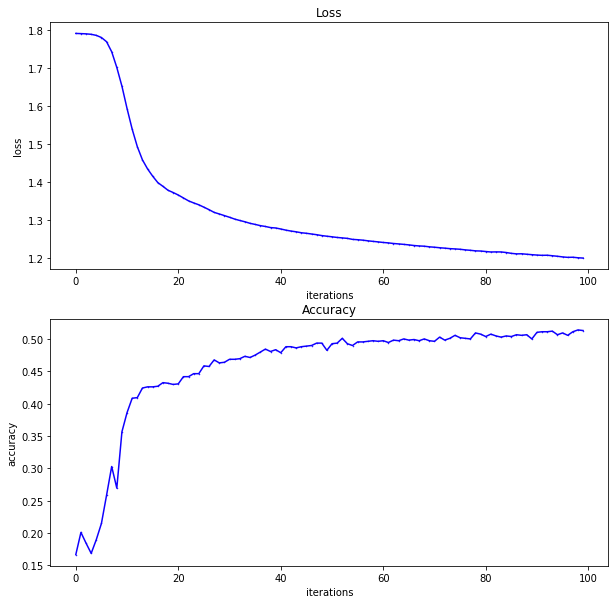

In [14]:
loss = model.history['loss']
metric = model.history['metric']

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2, 1, 1)
ax1.set_title('Loss')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')
ax2 = fig.add_subplot(2, 1, 2)
ax2.set_title('Accuracy')
ax2.set_xlabel('iterations')
ax2.set_ylabel('accuracy')
ax2.plot(metric, marker='.', color='#0F00FF', markersize=1, linestyle='-')

It's a 2


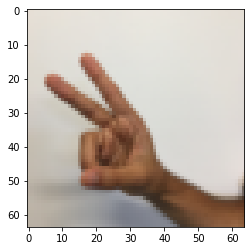

In [15]:
index = 6
plt.imshow(X_train[index,:,:,:])
print("It's a {}".format(np.argmax(model.predict(X_train[[index],:,:,:]))))

It's a 3


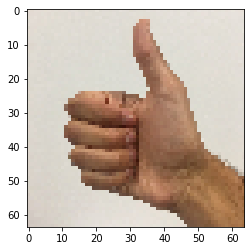

In [16]:
img = np.array(plt.imread("thumbs_up.jpg"))
img_ = np.array(Image.fromarray(img).resize((64,64)))
plt.imshow(img_)
img__ = np.expand_dims(img_, axis=0)
print("It's a {}".format(np.argmax(model.predict(img__))))

It's a 1


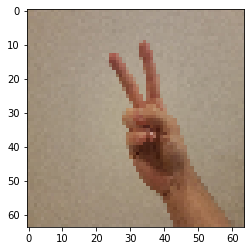

In [17]:
img = np.array(plt.imread("two_fingers.jpg"))
img_ = np.array(Image.fromarray(img).resize((64,64)))
plt.imshow(img_)
img__ = np.expand_dims(img_, axis=0)
print("It's a {}".format(np.argmax(model.predict(img__))))

It's a 0


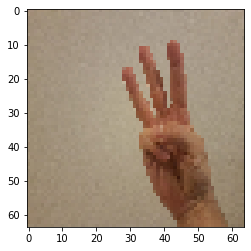

In [18]:
img = np.array(plt.imread("three_fingers.jpg"))
img_ = np.array(Image.fromarray(img).resize((64,64)))
plt.imshow(img_)
img__ = np.expand_dims(img_, axis=0)
print("It's a {}".format(np.argmax(model.predict(img__))))